In [22]:
import pandas as pd
import datetime as dt
import requests
import json
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:

hospital = pd.read_csv('Data Files/NSS_Hospital_Inpatient_Admissions.csv')
pcp = pd.read_csv('Data Files/NSS_PrimaryCare_Office_Visits.csv')
members = pd.read_csv('Data Files/NSS_GreatCare_Members.csv')

#drop hospital dupss
hospital_wo_dups = hospital.sort_values(by = ['Patient ID', 'Encounter Start Date', 'Encounter End Date']).drop_duplicates(subset = ['Patient ID','Encounter Start Date'], keep = 'last')
hospital_wo_dups = hospital_wo_dups.sort_values(by = ['Patient ID', 'Encounter End Date', 'Encounter Start Date']).drop_duplicates(subset = ['Patient ID','Encounter End Date'], keep = 'first')
hospital_wo_dups = hospital_wo_dups.drop_duplicates(subset = ['Patient ID','Encounter Start Date', 'Encounter End Date'], keep='first')

pcp['Attending Provider NPI'] = pcp['Attending Provider NPI'].astype(str)
pcp['Facility Provider NPI'] = pcp['Facility Provider NPI'].astype(str)
pcp['Service Provider NPI'] = pcp['Service Provider NPI'].astype(str)
pcp['Provider Group NPI'] = pcp['Provider Group NPI'].astype(str)

pcp['Attending Provider NPI'] = pcp['Attending Provider NPI'].str.replace("\.0","")
pcp['Facility Provider NPI'] = pcp['Facility Provider NPI'].str.replace("\.0","")
pcp['Service Provider NPI'] = pcp['Service Provider NPI'].str.replace("\.0","")
pcp['Provider Group NPI'] = pcp['Provider Group NPI'].str.replace("\.0","")

F:\Users\julie\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (3,5,17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-2-5c655b779838>:15: FutureWarning: The default value of regex will change from True to False in a future version.
  pcp['Attending Provider NPI'] = pcp['Attending Provider NPI'].str.replace("\.0","")
<ipython-input-2-5c655b779838>:16: FutureWarning: The default value of regex will change from True to False in a future version.
  pcp['Facility Provider NPI'] = pcp['Facility Provider NPI'].str.replace("\.0","")
<ipython-input-2-5c655b779838>:17: FutureWarning: The default value of regex will change from True to False in a future version.
  pcp['Service Provider NPI'] = pcp['Service Provider NPI'].str.replace("\.0","")
<ipython-input-2-5c655b779838>:18: FutureWarning: The default value of regex will change from True to False i

In [3]:
hospital_wo_dups['Encounter Start Date'] = pd.to_datetime(hospital['Encounter Start Date'])
hospital_wo_dups['Encounter End Date'] = pd.to_datetime(hospital['Encounter End Date'])
pcp['Encounter Date'] = pd.to_datetime(pcp['Encounter Date'])
pcp = pcp.reset_index(drop = True)

In [4]:
hospital_wo_dups['is_index_event'] = False
hospital_wo_dups['has_readmit'] = 0


plus_30 = dt.timedelta(days=31)


for index, elem in hospital_wo_dups.drop_duplicates(subset = 'Patient ID', keep= 'first').iterrows():
    
    patient_id = hospital_wo_dups.loc[index, 'Patient ID']
    encounter_end_dates = hospital_wo_dups['Encounter End Date'][hospital_wo_dups['Patient ID'] == patient_id]
    encounter_start_dates = hospital_wo_dups['Encounter Start Date'][hospital_wo_dups['Patient ID'] == patient_id]
    
    
    while encounter_start_dates.empty == False:
        hospital_wo_dups['is_index_event'][(hospital_wo_dups['Encounter Start Date'] == min(encounter_start_dates)) & (hospital_wo_dups['Patient ID'] == patient_id)] = True
        next_index =  min(encounter_end_dates) + plus_30
    
        for index, item in encounter_start_dates.iteritems():
            if item < next_index:
                encounter_start_dates.drop(labels = index, inplace = True)
                encounter_end_dates.drop(labels = index, inplace = True)
                
hospital_wo_dups = hospital_wo_dups.sort_values(['Patient ID', 'Encounter Start Date']).reset_index(drop=True)               
for index, elem in hospital_wo_dups.iterrows():
    if hospital_wo_dups.loc[index, 'is_index_event'] == True:
        last_index = hospital_wo_dups.loc[index, 'Encounter End Date']
        index_of_last_index = index

    else:
        if hospital_wo_dups.loc[index, 'Encounter Start Date'] < (last_index + plus_30):
            hospital_wo_dups.loc[index_of_last_index, 'has_readmit'] = 1

    
print("number of index events is " + str(hospital_wo_dups[hospital_wo_dups['is_index_event'] == True].shape[0]))
print("30 day readmit proportion is " + str(hospital_wo_dups['has_readmit'].value_counts()[1]/hospital_wo_dups['is_index_event'].value_counts()[1]))

<ipython-input-4-3c945affbeaf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hospital_wo_dups['is_index_event'][(hospital_wo_dups['Encounter Start Date'] == min(encounter_start_dates)) & (hospital_wo_dups['Patient ID'] == patient_id)] = True


number of index events is 5536
30 day readmit proportion is 0.09519508670520231


In [5]:
hospital_wo_dups['pcp_visit'] = 0
plus_7 = dt.timedelta(days=7)


for index, elem in hospital_wo_dups.iterrows():
    
    patient_id = hospital_wo_dups.loc[index, 'Patient ID']
    
    if pcp['Encounter Date'][(pcp['Patient ID'] == patient_id) & 
                             (pcp['Encounter Date'] >=hospital_wo_dups.loc[index, 'Encounter End Date']) & 
                             (pcp['Encounter Date'] <= (hospital_wo_dups.loc[index, 'Encounter End Date'] 
                                                        + plus_7))].empty == False:
            hospital_wo_dups.loc[index, 'pcp_visit'] = 1

In [7]:
npi = pd.read_csv('Data Files/npi.csv')

In [8]:
hospital_wo_dups['facility provider']= ""
hospital_wo_dups['attending provider']= ""


hospital_wo_dups['Attending Provider NPI']  = hospital_wo_dups['Attending Provider NPI'].astype(str)
hospital_wo_dups['Facility Provider NPI']  = hospital_wo_dups['Facility Provider NPI'].astype(str)

hospital_wo_dups['Attending Provider NPI']  = hospital_wo_dups['Attending Provider NPI'].str.replace("\.0","")
hospital_wo_dups['Facility Provider NPI']  = hospital_wo_dups['Facility Provider NPI'].str.replace("\.0","")


for index, elem in hospital_wo_dups.iterrows():
    res = npi.loc[npi['npi'] == elem['Facility Provider NPI'], 'entry'].reset_index().iloc[0].entry
    
    try:
        dict = eval(res)
        hospital_wo_dups.loc[index, 'facility provider'] = dict['basic']['name']
    except:
            hospital_wo_dups.loc[index, 'facility provider'] = "unavailable"
                    
    
    try:
        res = npi.loc[npi['npi'] == elem['Attending Provider NPI'], 'entry'].reset_index().iloc[0].entry

        try:
            dict = eval(res)
            hospital_wo_dups.loc[index, 'attending provider'] = dict['basic']['name']
        except:
            hospital_wo_dups.loc[index, 'attending provider'] = "deactivated NPI"
    except:
        hospital_wo_dups.loc[index, 'attending provider'] = "error"

<ipython-input-8-7c1520709a6e>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  hospital_wo_dups['Attending Provider NPI']  = hospital_wo_dups['Attending Provider NPI'].str.replace("\.0","")
<ipython-input-8-7c1520709a6e>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  hospital_wo_dups['Facility Provider NPI']  = hospital_wo_dups['Facility Provider NPI'].str.replace("\.0","")


In [9]:
pcp = hospital_wo_dups['facility provider'][hospital_wo_dups['pcp_visit'] == 1].value_counts()
pcp = pcp.reset_index()
pcp = pcp.rename(columns = {'index': 'Facility', 'facility provider' :  'pcp visit count'})

In [10]:
readmits = hospital_wo_dups['facility provider'][hospital_wo_dups['has_readmit'] == 1].value_counts()
readmits = readmits.reset_index()
readmits = readmits.rename(columns = {'index': 'Facility', 'facility provider' :  'readmit count'})

In [13]:
total_counts = pd.DataFrame(hospital_wo_dups['facility provider'].value_counts())
total_counts = total_counts.reset_index()
total_counts = total_counts.rename(columns = {'index': 'Facility', 'facility provider' :  'total count'})
total_counts = total_counts.merge(right = readmits, how = 'outer', on= 'Facility')
total_counts['percent_readmits'] = (total_counts['readmit count'] /total_counts['total count'])*100
total_counts = total_counts.merge(right = pcp, how = 'outer', on= 'Facility')
total_counts['percent_pcps'] = (total_counts['pcp visit count'] /total_counts['total count'])*100
total_counts

,Facility,total count,readmit count,percent_readmits,pcp visit count,percent_pcps
0,REGENTS UNIV OF CALIF LOS ANGELES,1207,83.0,6.876553,437.0,36.205468
1,UCSD MEDICAL CENTER,1196,93.0,7.775920,371.0,31.020067
2,REGENTS OF THE UNIV OF CALIFORNIA,885,83.0,9.378531,329.0,37.175141
3,"UNIVERSITY OF CALIFORNIA, SAN FRANCISCO",678,60.0,8.849558,246.0,36.283186
4,UNIVERSITY OF CALIFORNIA SAN FRANCISCO MEDICAL...,448,33.0,7.366071,11.0,2.455357
...,...,...,...,...,...,...
157,LODI MEMORIAL HOSPITAL ASSOCIATION INC,1,1.0,100.000000,1.0,100.000000
158,"ALHAMBRA HOSPITAL MEDICAL CENTER, LP",1,NaN,NaN,1.0,100.000000
159,RHODE ISLAND HOSPITAL,1,NaN,NaN,NaN,NaN
160,SEQUOIA HEALTH SERVICES,1,NaN,NaN,NaN,NaN


In [109]:
finalcsv = pd.read_csv('Data Files/NPI_and_addresses_clean.csv')
finalcsv.head(11)

,Facility NPI,total count,readmit count,percent_readmits,pcp visit count,percent_pcps,facility provider,concat address,Unnamed: 0_y,npi_type,...,name,taxonomy_1,taxonomy_2,taxonomy_3,taxonomy_4,taxonomy raw,address_y,city,state,zip
0,1902803315,1201,83.0,6.910908,436.0,36.303081,RONALD REAGAN UCLA MEDICAL CENTER,757 WESTWOOD PLZ LOS ANGELES CA 900958358,1906.0,NPI-2,...,REGENTS UNIV OF CALIF LOS ANGELES,General Acute Care Hospital,na,na,na,"[{'code': '282N00000X', 'desc': 'General Acute...",757 WESTWOOD PLZ,LOS ANGELES,CA,900958358.0
1,1184722779,1195,93.0,7.782427,371.0,31.046025,"UNIVERSITY OF CALIFORNIA SAN DIEGO, MEDICAL CE...",200 WEST ARBOR DRIVE SAN DIEGO CA 921038937,1911.0,NPI-2,...,UCSD MEDICAL CENTER,General Acute Care Hospital,na,na,na,"[{'code': '282N00000X', 'desc': 'General Acute...",200 WEST ARBOR DRIVE,SAN DIEGO,CA,921038937.0
2,1427055839,885,83.0,9.378531,329.0,37.175141,SANTA MONICAUCLAMC AND ORTHOPEDIC HOSPITAL,1250 16TH ST SANTA MONICA CA 904041249,1907.0,NPI-2,...,REGENTS OF THE UNIV OF CALIFORNIA,General Acute Care Hospital,na,na,na,"[{'code': '282N00000X', 'desc': 'General Acute...",1250 16TH ST,SANTA MONICA,CA,904041249.0
3,1689772592,678,60.0,8.849558,246.0,36.283186,UCSF MEDICAL CENTER,505 PARNASSUS AVE SAN FRANCISCO CA 941430296,1917.0,NPI-2,...,"UNIVERSITY OF CALIFORNIA, SAN FRANCISCO",General Acute Care Hospital,na,na,na,"[{'code': '282N00000X', 'desc': 'General Acute...",505 PARNASSUS AVE,SAN FRANCISCO,CA,941430296.0
4,1033298617,448,33.0,7.366071,11.0,2.455357,UCSF DERMATOLOGY,400 PARNASSUS AVE SAN FRANCISCO CA 941432202,1919.0,NPI-2,...,UNIVERSITY OF CALIFORNIA SAN FRANCISCO MEDICAL...,Dermatology,Dermatology Dermatopathology,Dermatology Pediatric Dermatology,na,"[{'code': '207N00000X', 'desc': 'Dermatology',...",400 PARNASSUS AVE,SAN FRANCISCO,CA,941432202.0
5,1710918545,436,32.0,7.339450,140.0,32.110092,UNIVERSITY OF CALIFORNIA DAVIS MEDICAL CENTER,2315 STOCKTON BLVD SACRAMENTO CA 958172201,1912.0,NPI-2,...,REGENTS OF THE UNIVERSITY OF CALIFORNIA,General Acute Care Hospital,na,na,na,"[{'code': '282N00000X', 'desc': 'General Acute...",2315 STOCKTON BLVD,SACRAMENTO,CA,958172201.0
6,1689608150,339,28.0,8.259587,114.0,33.628319,UCI MEDICAL CENTER,101 THE CITY DR S ORANGE CA 92868,1914.0,NPI-2,...,UNIVERSITY OF CALIFORNIA IRVINE,General Acute Care Hospital,na,na,na,"[{'code': '282N00000X', 'desc': 'General Acute...",101 THE CITY DR S,ORANGE,CA,92868.0
7,1710065933,109,6.0,5.504587,38.0,34.862385,CHILDREN'S HOSPITAL - SAN DIEGO,3020 CHILDRENS WAY SAN DIEGO CA 921234223,1924.0,NPI-2,...,RADY CHILDREN'S HOSPITAL - SAN DIEGO,Clinic/Center,Clinic/Center End-Stage Renal Disease (ESRD) T...,Clinic/Center Hearing and Speech,Clinic/Center Adolescent and Children Mental H...,"[{'code': '261Q00000X', 'desc': 'Clinic/Center...",3020 CHILDRENS WAY,SAN DIEGO,CA,921234223.0
8,1992818256,87,8.0,9.195402,NaN,NaN,UCSF MEDICAL CENTER ADULT CHRONIC DIALYSIS,1675 SCOTT ST SAN FRANCISCO CA 941430001,1908.0,NPI-2,...,UNIVERSITY OF CALIFORNIA SAN FRANCISCO,Clinic/Center End-Stage Renal Disease (ESRD) T...,na,na,na,"[{'code': '261QE0700X', 'desc': 'Clinic/Center...",1675 SCOTT ST,SAN FRANCISCO,CA,941430001.0
9,0,87,11.0,12.643678,26.0,29.885057,UNKNOWN,,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [110]:
top_10 = finalcsv.head(11)
top_10_r = top_10.sort_values(by = "percent_readmits", ascending=False)
top_10_r
top_10_p = top_10.sort_values(by = "percent_pcps", ascending=True)

In [60]:
total_counts.to_csv('hospital_breakdown.csv')

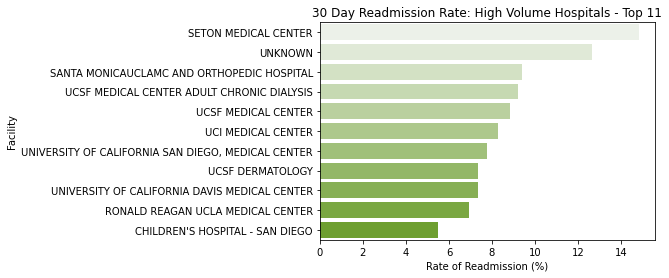

In [140]:
ax = sns.barplot(x="percent_readmits", y="facility provider", data=top_10_r, palette = "light:#70B11D")
plt.xlabel('Rate of Readmission (%)')
plt.ylabel('Facility')
plt.title("30 Day Readmission Rate: High Volume Hospitals - Top 11")
sns.color_palette("light:#70B11D", as_cmap=True)

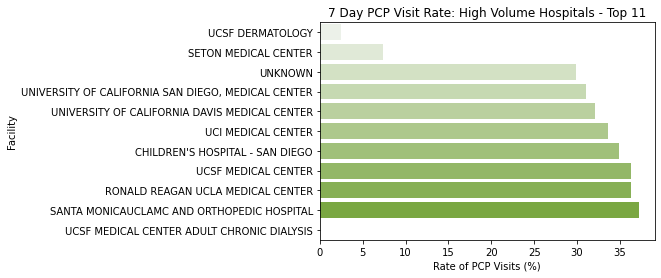

In [139]:
ax2 = sns.barplot(x="percent_pcps", y="facility provider", data=top_10_p, palette = "light:#70B11D")
plt.xlabel('Rate of PCP Visits (%)')
plt.ylabel('Facility')
plt.title("7 Day PCP Visit Rate: High Volume Hospitals - Top 11")
sns.color_palette("light:#70B11D", as_cmap=True)